# This notebook checks the results after a simulation

## init stuff

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [18]:
import os
import glob
from result_utils.results_utils import xml2csv_path
import pandas as pd
import matplotlib.pyplot as plt
import json

In [4]:
path = '../experiment/Results'


In [5]:
result_folders = os.listdir(path)

In [6]:
experiment_name = 'counterfactual_test'
experiment_folders = [folder for folder in result_folders if folder.startswith(experiment_name)]

In [7]:
experiment_folders

['counterfactual_test_86',
 'counterfactual_test_11',
 'counterfactual_test_7',
 'counterfactual_test_28',
 'counterfactual_test_31',
 'counterfactual_test_95',
 'counterfactual_test_90',
 'counterfactual_test_34',
 'counterfactual_test_84',
 'counterfactual_test_94',
 'counterfactual_test_23',
 'counterfactual_test_37',
 'counterfactual_test_5',
 'counterfactual_test_55',
 'counterfactual_test_48',
 'counterfactual_test_32',
 'counterfactual_test_60',
 'counterfactual_test_43',
 'counterfactual_test_40',
 'counterfactual_test_29',
 'counterfactual_test_3',
 'counterfactual_test_49',
 'counterfactual_test_9',
 'counterfactual_test_72',
 'counterfactual_test_62',
 'counterfactual_test_61',
 'counterfactual_test_30',
 'counterfactual_test_57',
 'counterfactual_test_6',
 'counterfactual_test_53',
 'counterfactual_test_66',
 'counterfactual_test_78',
 'counterfactual_test_22',
 'counterfactual_test_35',
 'counterfactual_test_13',
 'counterfactual_test_64',
 'counterfactual_test_80',
 'coun

In [13]:
for folder in experiment_folders:
    result_xmls = [xml for xml in glob.glob(f'{path}/{folder}/*.xml') if 'log' not in xml]
    if len(glob.glob(f'{path}/{folder}/*.csv')) < len(result_xmls):
        print(f'Found fewer csv files than xml files in {folder}. Converting results')
        xml2csv_path(f'{path}/{folder}')
        print(f'finished converting {folder}')
    else:
        print(f"All files in {folder} seems converted.")

All files in counterfactual_test_86 seems converted.
All files in counterfactual_test_11 seems converted.
All files in counterfactual_test_7 seems converted.
All files in counterfactual_test_28 seems converted.
All files in counterfactual_test_31 seems converted.
All files in counterfactual_test_95 seems converted.
All files in counterfactual_test_90 seems converted.
All files in counterfactual_test_34 seems converted.
All files in counterfactual_test_84 seems converted.
All files in counterfactual_test_94 seems converted.
All files in counterfactual_test_23 seems converted.
All files in counterfactual_test_37 seems converted.
All files in counterfactual_test_5 seems converted.
All files in counterfactual_test_55 seems converted.
All files in counterfactual_test_48 seems converted.
All files in counterfactual_test_32 seems converted.
All files in counterfactual_test_60 seems converted.
All files in counterfactual_test_43 seems converted.
All files in counterfactual_test_40 seems conver

## check counterfactuals

In [74]:
experiment = experiment_folders[5]
experiment_path = f'{path}/{experiment}'

In [75]:
print(experiment_path)
os.listdir(experiment_path)

../experiment/Results/counterfactual_test_95


['error_log_counterfactual.xml',
 'edgedata_counterfactual.csv',
 'message_log.xml',
 'incident_settings.json',
 'edgedata_counterfactual.xml',
 'message_log_counterfactual.xml',
 'edgedata.csv',
 'edgedata.xml',
 'error_log.xml']

In [76]:
with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
incident_settings

{'run_num': 95,
 'is_incident': True,
 'is_random': True,
 'random_seed': 1443620295,
 'edge': 'E4',
 'lanes': [2, 0, 1],
 'pos': 36.95032381785954,
 'start_time': 6329,
 'start_step': 12658,
 'duration_time': 1300,
 'duration_steps': 2600}

In [77]:
incident_settings['lanes']

[2, 0, 1]

In [78]:
results_incident = pd.read_csv(f'{experiment_path}/edgedata.csv', sep=';')
results_incident = results_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
results_incident_table = results_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

counterfactual_incident = pd.read_csv(f'{experiment_path}/edgedata_counterfactual.csv', sep=';')
counterfactual_incident = counterfactual_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
counterfactual_incident_table = counterfactual_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

<AxesSubplot:xlabel='interval_begin'>

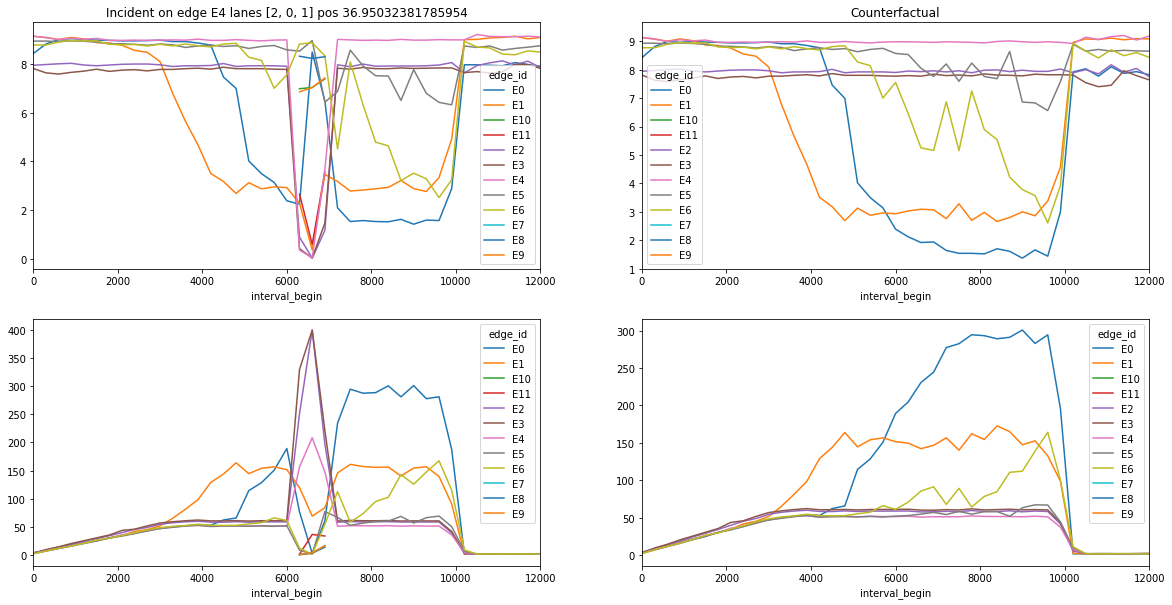

In [90]:
fig, ax = plt.subplots(2,2)

results_incident_table.edge_speed.T.plot(figsize=(20,10), ax=ax[0,0])
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')

results_incident_table.edge_density.T.plot(figsize=(20,10), ax=ax[1,0])

counterfactual_incident_table.edge_speed.T.plot(figsize=(20,10), ax=ax[0,1])
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(0,12000)
ax[1,0].set_xlim(0,12000)
ax[0,1].set_xlim(0,12000)
ax[1,1].set_xlim(0,12000)

counterfactual_incident_table.edge_density.T.plot(figsize=(20,10), ax=ax[1,1])



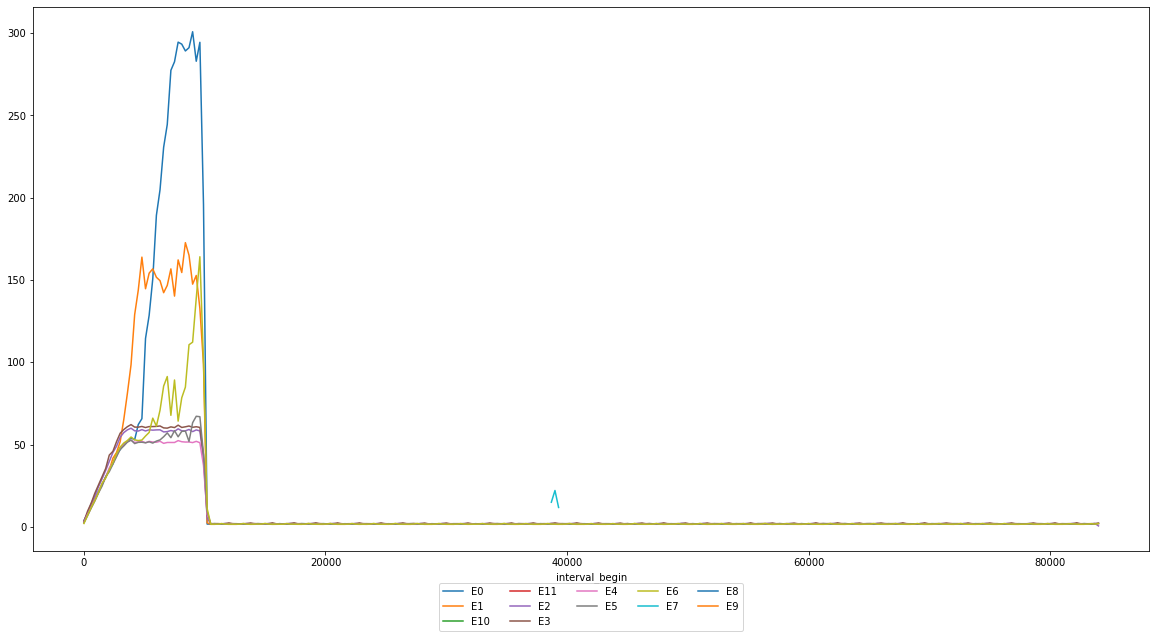